### QuasarNET: Inspect DESI sims

This notebook will walk you through how to run [QuasarNET](https://arxiv.org/pdf/1808.09955.pdf]):
 * load training data
 * load DESI sims validation data
 * train the network (on a small training sample, optional)
 * load pre-trained weights
 * plot example spectra
 * produce QA plots and confusion matrix

#### Installation instructions (requires python3):
##### - on a standard system

```bash
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
pip install -r requirements.txt --user
python setup.py install --user
```

##### - at NERSC (e.g. if you wish to run this notebook at jupyter.nersc.gov)

```bash
conda create -n qnet python=3 qnet scipy numpy fitsio h5py ipykernel
source activate qnet
python -m ipykernel install --user --name qnet --display-name qnet
pip install tensorflow
pip install keras>=2.2.4
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
python setup.py install
```

#### - Download the pre-trained weights
The pre-trained weights are available at: https://www.kaggle.com/ngbusca/qnet_trained_models

Download the weights to the `QuasarNET/weights/` directory, unzip the file and set read/write permissions
(skip the `kaggle datasets...` line if you've downloaded the data through the website).

```bash
cd weights
kaggle datasets download ngbusca/qnet_trained_models
unzip qnet_trained_models.zip
chmod 600 *
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import fitsio
from keras.models import load_model
from quasarnet.models import custom_loss
from quasarnet.io import read_desi_spectra, wave
from quasarnet.utils import process_preds, absorber_IGM
%matplotlib inline

Using TensorFlow backend.


#### Load the DESI sims

The next cell loads all spectra from a spectra file. It firsts gets the resampled fluxes on the QNet wavelength grid, then removes the mean and sets the rms of the flux to 1.

In [2]:
file = '/global/projecta/projectdirs/desi/mocks/lya_forest/london/v4.0/quick-0.0/spectra-16/0/0/spectra-16-0.fits'
tids_val, flux = read_desi_spectra(file, ignore_quasar_mask=True)
mflux = np.average(flux[:,:443], weights=flux[:,443:],axis=1)
sflux = np.average((flux[:,:443]-mflux[:,None])**2, weights=flux[:,443:], axis=1)
sflux = np.sqrt(sflux)
X_val = (flux[:,:443]-mflux[:,None])/sflux[:,None]
nspec = X_val.shape[0]

WARN: can't load desi_mask, ignoring mask!
INFO: found 1021 quasar targets
INFO: founds 1021 good spectra


#### Define the "features" that the network was trained to recognize

The features are defined by their rest wavelength. 
A dictionary `{feature_name:feature_wavelength}` is defined in `quasarnet.util.absorber_IGM`, which currently contains typical quasar broad emission lines. It could be easily extended to include other features by extending the dictionary.

In [3]:
lines=['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal=['CIV(1548)']

#### Load a pre-trained model

The following cell loads pre-trained weights for the network, corresponding to the split defined earlier. The pre-training was done over the full training data sample and 200 epochs.

In [4]:
imodel=0
#model = load_model('../weights/qn_train_{}.h5'.format(imodel),custom_objects={'custom_loss':custom_loss})
model = load_model('../runs/v18.0/qn_train_{}.h5'.format(imodel),custom_objects={'custom_loss':custom_loss})

#### Example spectra

Let's now take a look at the network output by examining a few examples. If you skipped loading the pre-trained weights you will be looking at the model you trained (it's actually not that bad!).

The network outputs confidences and positions of the features defined earlier. The following plot shows a spectrum from the validation sample and the detected features. You can change the index `ival` to change the spectrum to be shown.

INFO: nspec = 1, nboxes=13


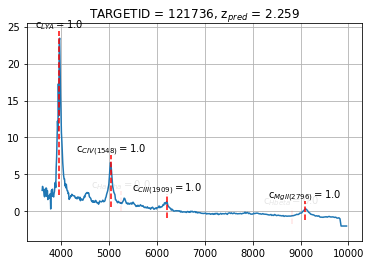

In [5]:
ival = 900
p=model.predict(X_val[ival:ival+1,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)
plt.plot(wave, X_val[ival])
plt.title(r'TARGETID = {}, z$_{{pred}}$ = {}'.format(tids_val[ival],round(zbest[0],3)))
m = X_val[ival].min()
M = X_val[ival].max()
plt.grid()
plt.ylim(m-2,M+2)
for il,l in enumerate(lines):
    lam = absorber_IGM[l]*(1+z_line[il])
    w = abs(wave-lam)<100
    m = X_val[ival,w].min()-1
    M = X_val[ival,w].max()+1
    plt.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il])
    plt.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,0],3)),
             horizontalalignment='center',alpha=0.1+0.9*c_line[il])
    

#### Quality assesment

The next cells assume that simulated spectra are all quasars and there are no BALs in the sample. 

QuasarNET calls a spectrum a quasar if there are more than `nlines` detected with a confidence greater than `c_th`, and similarly for BAL quasars.

In [6]:
## minimum number of lines required for quasar
nlines = 1
## line detection threshold
c_th = 0.8

## same thing for BAL
nlines_bal = 1
c_th_bal = 0.5

In [7]:
p=model.predict(X_val[:,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)
isqso = (c_line>c_th).sum(axis=0)>=nlines
isbal = isqso & ((c_line_bal>c_th_bal).sum(axis=0)>=nlines_bal)
nqso = isqso.sum()
nbal = isbal.sum()

print('INFO: found {} QSOs out of {} spectra'.format(nqso, nspec))
print('INFO: found {} BAL out of {} spectra'.format(nbal, nspec))

INFO: nspec = 1021, nboxes=13
INFO: found 1021 QSOs out of 1021 spectra
INFO: found 0 BAL out of 1021 spectra


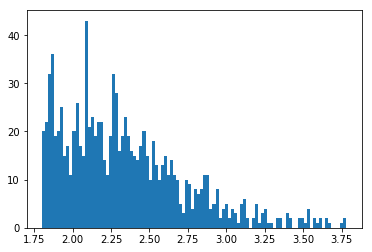

In [8]:
_=plt.hist(zbest, bins=100)